In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.estela import spatial_gradient, Predictor
from teslakit.util.time_operations import xds_common_dates_daily

from teslakit.plotting.estela import Plot_ESTELA
from teslakit.plotting.wts import Plot_Probs_WT_WT
from teslakit.plotting.waves import Plot_Waves_DWTs



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# load data and set parameters

ESTELA = db.Load_ESTELA_data()            # ESTELA D data
WAVES = db.Load_ESTELA_waves()            # ESTELA gow waves point
SLP = db.Load_ESTELA_SLP()                # ESTELA Sea Level Pressure

WAVES_parts = db.Load_WAVES_partitions()  # waves partitions data

_, TCs_r1_params = db.Load_TCs_r1_hist()  # TCs historical parameters inside 14º radius 

# KMA REGRESSION GUIDED parameters
kma_date_ini = '1979-01-22'
kma_date_end = '2011-01-22'
num_clusters = 36
kmarg_alpha = 0.36



## ESTELA Predictor - Sea Level Pressure and Gradient

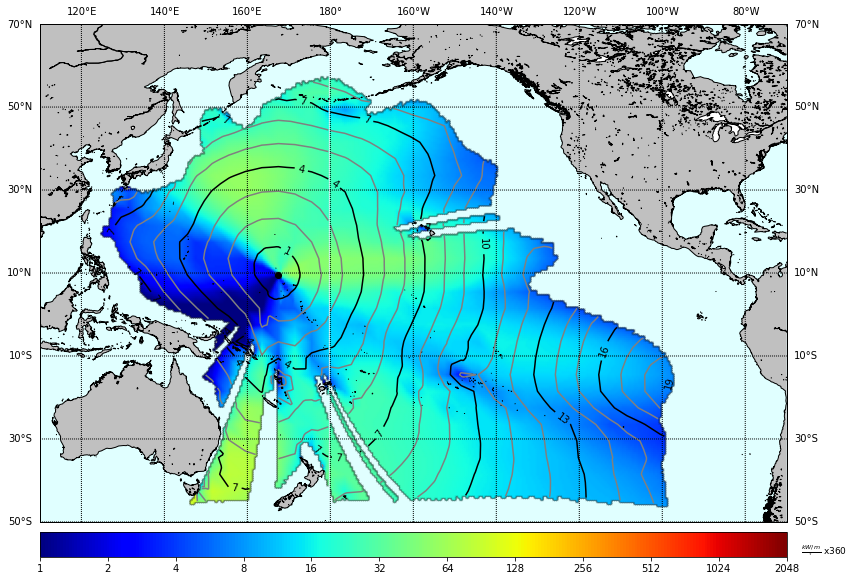

In [4]:
# --------------------------------------
# Plot ESTELA and wave point coordinates

mask_plot = ESTELA.mask_e95

Plot_ESTELA(
    ESTELA.pnt_longitude, ESTELA.pnt_latitude,
    ESTELA.F_y1993to2012 * mask_plot, 
    ESTELA.D_y1993to2012 * mask_plot,
    lon1 = 110, lon2 = 290, lat1 = -50, lat2 = 70,
);


In [5]:
# --------------------------------------
# ESTELA waves data: calculate Fe, resample to daily

# calculate Fe
Fe = np.multiply(WAVES.hs**2, WAVES.t02)**(1.0/3)
WAVES.update({'Fe' : (('time',), Fe)})

# select time window and calculate daily mean
WAVES = WAVES.sel(time = slice(kma_date_ini, kma_date_end)).resample(time='1D').mean()
    
print(WAVES)


<xarray.Dataset>
Dimensions:  (time: 11689)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-22 1979-01-23 ... 2011-01-22
Data variables:
    fp       (time) float64 0.1037 0.09292 0.09458 ... 0.07067 0.06604 0.07121
    hs       (time) float64 3.105 2.933 2.88 2.24 ... 2.177 2.395 2.55 2.305
    t02      (time) float64 6.059 6.032 5.998 5.773 ... 6.9 8.265 7.428 6.794
    dir      (time) float64 58.25 55.27 58.52 55.72 ... 159.7 351.0 165.9 10.58
    spr      (time) float64 39.06 40.38 36.42 38.68 ... 47.4 41.82 39.79 42.83
    hsCal    (time) float64 3.191 2.935 2.898 2.101 ... 2.006 2.09 2.379 2.23
    Fe       (time) float64 3.879 3.729 3.677 3.07 ... 3.198 3.619 3.641 3.304


In [6]:
# --------------------------------------
# Calculate site SLP & SLP_gradient (daily)

# select time window and do data daily mean
SLP_d = SLP.sel(time = slice(kma_date_ini, kma_date_end)).resample(time='1D').mean()

# calculate daily gradients
SLP_d = spatial_gradient(SLP_d, 'SLP')

print(SLP_d)
    

<xarray.Dataset>
Dimensions:       (latitude: 31, longitude: 83, time: 11689)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-22 1979-01-23 ... 2011-01-22
  * latitude      (latitude) float64 60.5 58.5 56.5 54.5 ... 6.5 4.5 2.5 0.5
  * longitude     (longitude) float64 115.0 117.0 119.0 ... 275.0 277.0 279.0
Data variables:
    SLP           (time, latitude, longitude) float64 1.019e+05 ... 1.009e+05
    SLP_gradient  (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0



## ESTELA Predictor - Principal Component Analysis

In [7]:
# --------------------------------------
# Calculate ESTELA PCA

# select ESTELA at site grid
ESTELA_site = ESTELA.sel(longitude = SLP.longitude, latitude = SLP.latitude)
estela_D = ESTELA_site.D_y1993to2012

# estela masks: data mask (95% energy) and land mask (plots)
estela_mask = ESTELA_site.mask_e95  
estela_land = ESTELA_site.mask_land

# apply ESTELA mask to SLP data
SLP_d['SLP'] = SLP_d.SLP * estela_mask
SLP_d['SLP_gradient'] = SLP_d.SLP_gradient * estela_mask
SLP_d['mask_land'] = estela_land


# Use our custom ESTELA Predictor 
pred = Predictor(db.paths.site.ESTELA.pred_slp)
pred.data = SLP_d

# PCA (dynamic estela predictor)
pred.Calc_PCA_EstelaPred('SLP', estela_D)

print(pred.PCA)


<xarray.Dataset>
Dimensions:        (n_components: 2142, n_features: 2142, n_lat: 31, n_lon: 83, n_points: 5146, time: 11668)
Dimensions without coordinates: n_components, n_features, n_lat, n_lon, n_points, time
Data variables:
    PCs            (time, n_components) float64 1.886 -8.676 ... 5.614e-19
    EOFs           (n_components, n_features) float64 0.03919 0.03962 ... 1.0
    variance       (n_components) float64 268.7 203.5 ... 1.319e-30 1.319e-30
    pred_mean      (n_features) float64 1.013e+05 1.012e+05 ... 0.0 0.0
    pred_std       (n_features) float64 536.6 473.9 636.0 608.9 ... 0.0 0.0 0.0
    pred_lon       (n_lon) float64 115.0 117.0 119.0 121.0 ... 275.0 277.0 279.0
    pred_lat       (n_lat) float64 60.5 58.5 56.5 54.5 52.5 ... 6.5 4.5 2.5 0.5
    pred_time      (time) datetime64[ns] 1979-02-12 1979-02-13 ... 2011-01-22
    pred_data_pos  (n_points) bool False False False False ... False False False
Attributes:
    method:     gradient + estela
    pred_name:  SLP


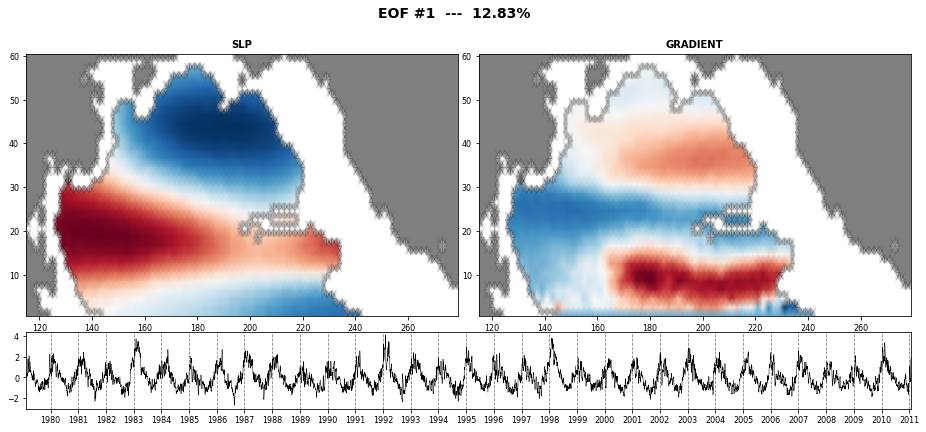

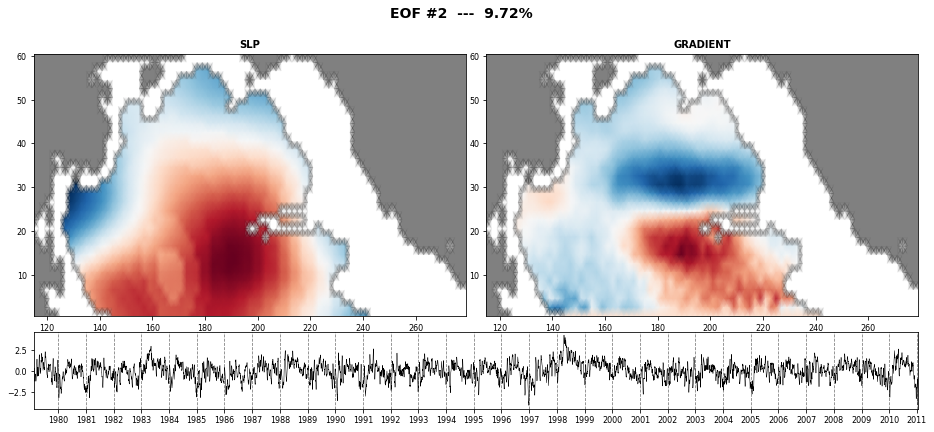

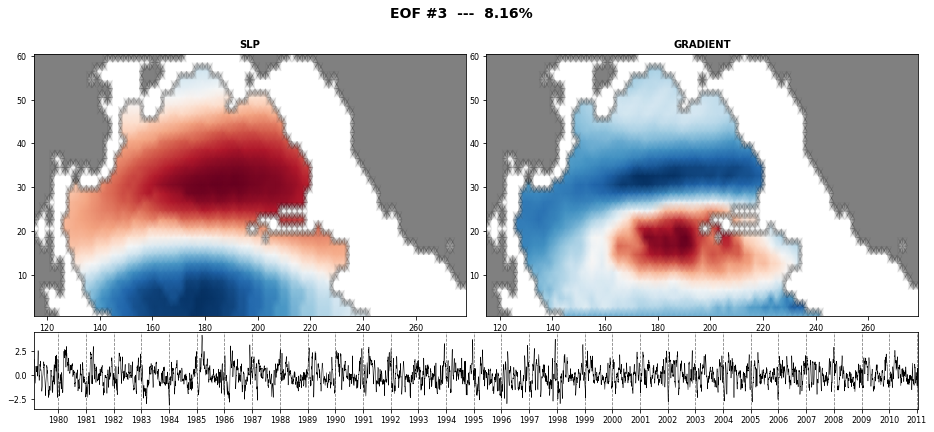

In [8]:
# plot PCA EOFs
n_EOFs = 3

pred.Plot_EOFs_EstelaPred(n_EOFs, show=True);



## ESTELA Predictor - KMeans Classification

In [9]:
# Calculate KMA (regression guided with WAVES data)

# TODO: encontrar alpha optimo?
pred.Calc_KMA_regressionguided(
    num_clusters,
    WAVES, ['hs','t02','Fe'],
    kmarg_alpha)

print(pred.KMA)


<xarray.Dataset>
Dimensions:           (n_clusters: 36, n_components: 11668, n_features: 237)
Dimensions without coordinates: n_clusters, n_components, n_features
Data variables:
    bmus              (n_components) int32 2 23 2 2 9 9 9 ... 14 14 14 14 14 14
    cenEOFs           (n_clusters, n_features) float64 -0.6341 ... 0.6877
    centroids         (n_clusters, n_features) float64 -16.24 -2.187 ... 3.654
    group_size        (n_clusters) int64 139 558 468 372 537 ... 224 344 471 23
    sorted_order      (n_clusters) int64 28 6 10 12 15 31 9 ... 8 32 17 5 22 21
    sorted_bmus       (n_components) int64 21 13 21 21 6 6 ... 25 25 25 25 25 25
    sorted_cenEOFs    (n_clusters, n_features) float64 0.6656 -0.5497 ... 0.1297
    sorted_centroids  (n_clusters, n_features) float64 17.04 -14.08 ... 2.82
    time              (n_components) datetime64[ns] 1979-02-12 ... 2011-01-22
Attributes:
    method:   regression guided
    alpha:    0.36


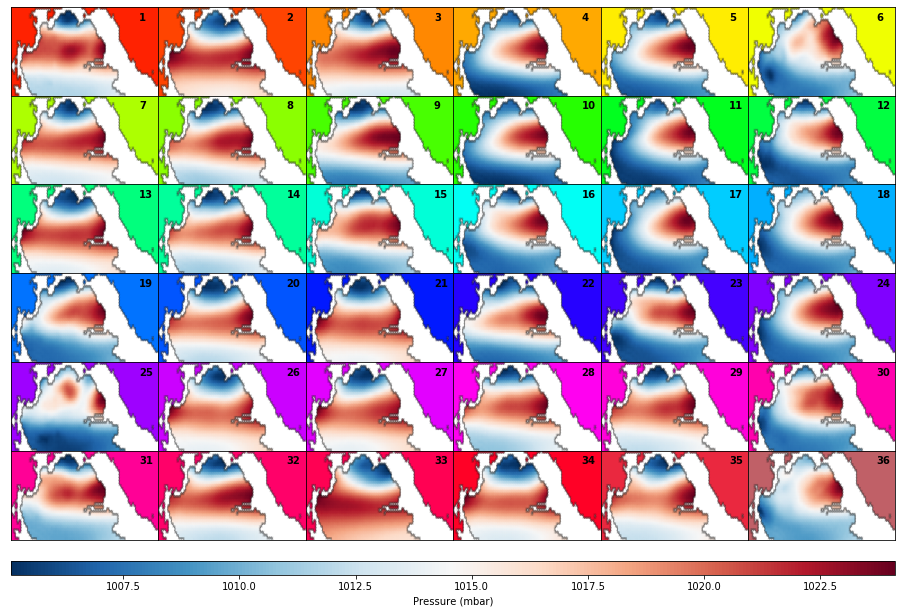

In [10]:
# Plot DWTs (data mean)
pred.Plot_DWTs('SLP', kind='mean', show=True);


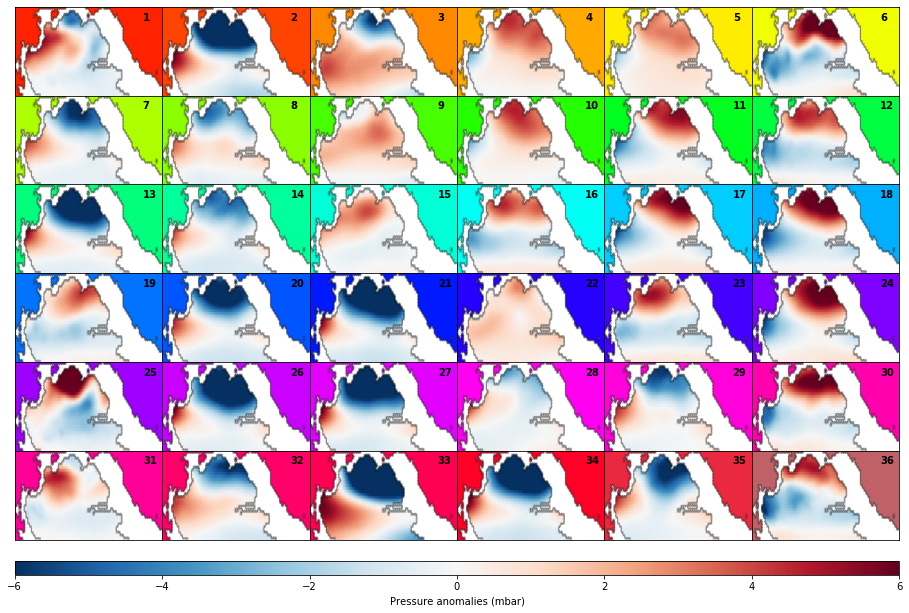

In [11]:
# Plot DWTs (data anomalies)
pred.Plot_DWTs('SLP', kind='anom', show=True);


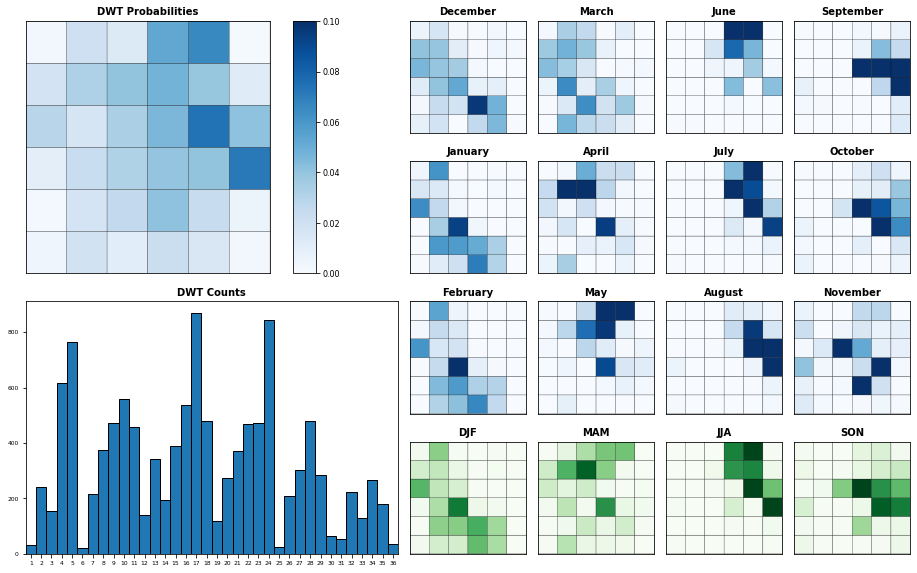

In [12]:
# Plot DWTs Probabilities
pred.Plot_DWTs_Probs();


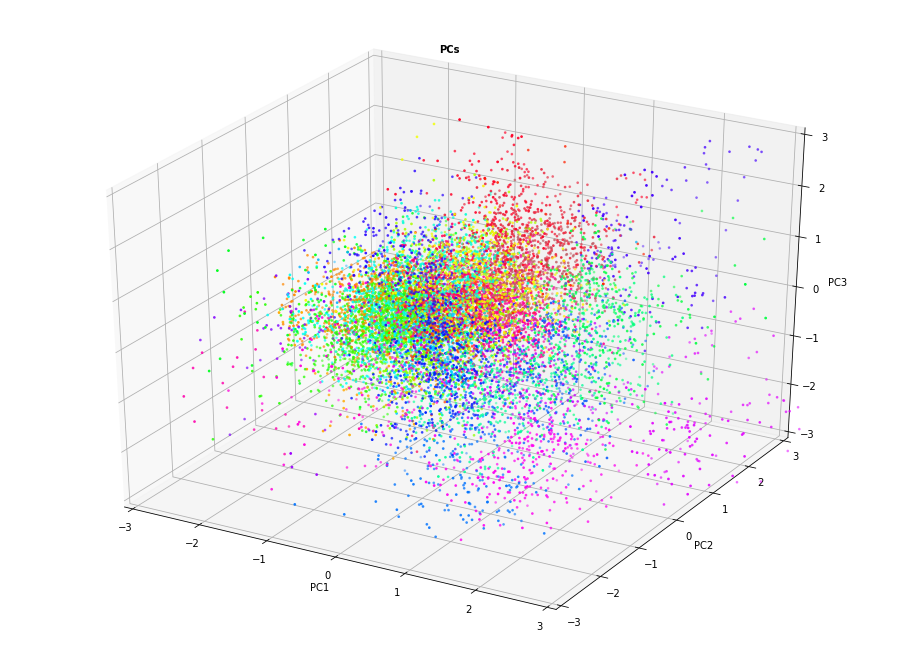

In [13]:
# Plot PC1, PC2, PC3 (3D)
pred.Plot_PCs_3D();


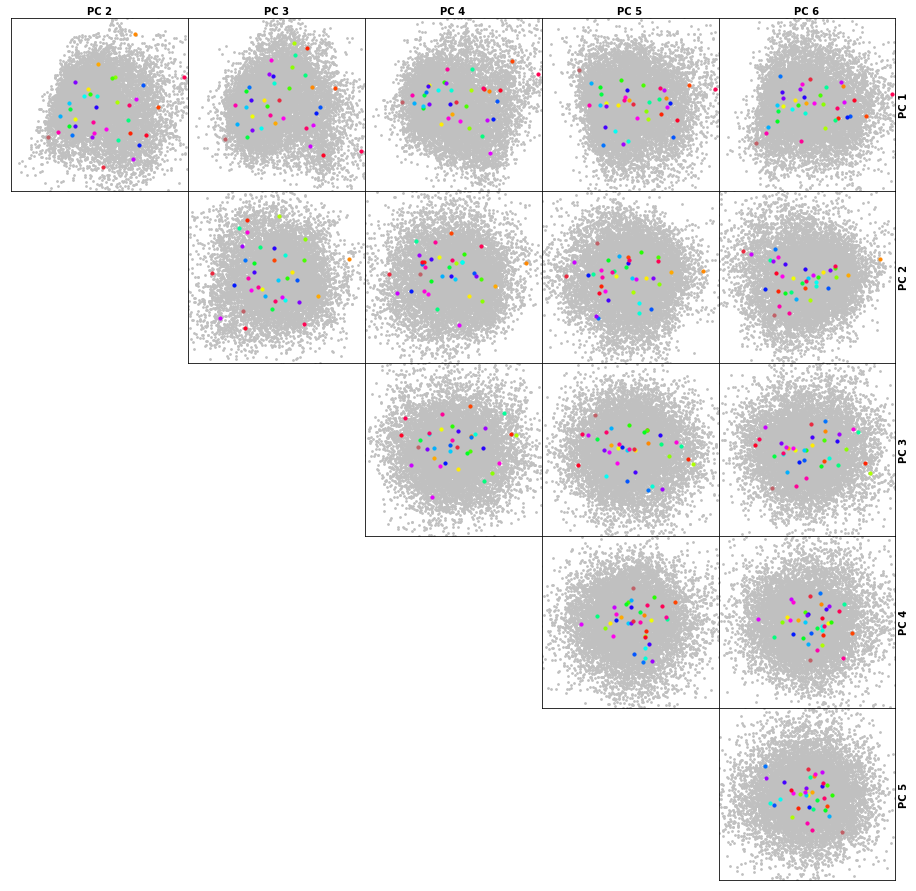

In [14]:
# Plot PCs DWT centroids
pred.Plot_DWT_PCs(n=6);



## ESTELA Predictor - Add Historical TCs

In [15]:
# --------------------------------------
# use historical storms-parameters inside r1 to modify predictor KMA results 

storm_dates = TCs_r1_params.dmin_date.values[:]
storm_categs = TCs_r1_params.category.values[:]

# add r1 storms to predictor KMA
pred.Mod_KMA_AddStorms(storm_dates, storm_categs)

print(pred.KMA)


<xarray.Dataset>
Dimensions:             (n_clusters: 36, n_components: 11668, n_features: 237)
Dimensions without coordinates: n_clusters, n_components, n_features
Data variables:
    bmus                (n_components) int32 2 23 2 2 9 9 ... 14 14 14 14 14 14
    cenEOFs             (n_clusters, n_features) float64 -0.6341 ... 0.6877
    centroids           (n_clusters, n_features) float64 -16.24 -2.187 ... 3.654
    group_size          (n_clusters) int64 139 558 468 372 ... 224 344 471 23
    sorted_order        (n_clusters) int64 28 6 10 12 15 31 ... 8 32 17 5 22 21
    sorted_bmus         (n_components) int64 21 13 21 21 6 6 ... 25 25 25 25 25
    sorted_cenEOFs      (n_clusters, n_features) float64 0.6656 ... 0.1297
    sorted_centroids    (n_clusters, n_features) float64 17.04 -14.08 ... 2.82
    time                (n_components) datetime64[ns] 1979-02-12 ... 2011-01-22
    sorted_bmus_storms  (n_components) int64 21 13 21 21 6 6 ... 25 25 25 25 25
Attributes:
    method:   regr

In [16]:
# --------------------------------------
# Calculate intradaily MU TAU hydrographs

l_MU_TAU = pred.Calc_MU_TAU_Hydrographs(WAVES_parts)

# store hydrographs MU TAU
db.Save_MU_TAU_hydrograms(l_MU_TAU)


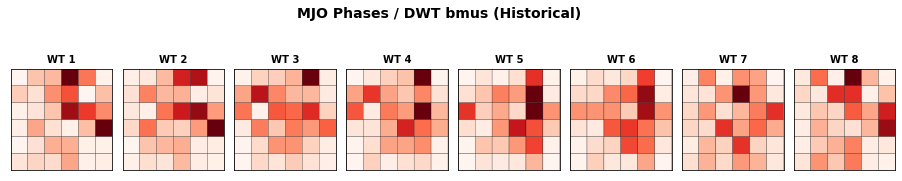

In [17]:
# Plot MJO phases / DWTs Probabilities 

# num. MJO phases and DWTs
MJO_ncs = 8
DWT_ncs = 36

# MJO, DWTs historical data
MJO_hist, DWT_hist = db.Load_MJO_DWTs_Plots_hist()

# categories to plot
MJO_phase = MJO_hist.phase.values[:]
DWT_bmus =  DWT_hist.bmus.values[:]

Plot_Probs_WT_WT(
    MJO_phase, DWT_bmus, MJO_ncs, DWT_ncs,
    wt_colors=False, ttl='MJO Phases / DWT bmus (Historical)');


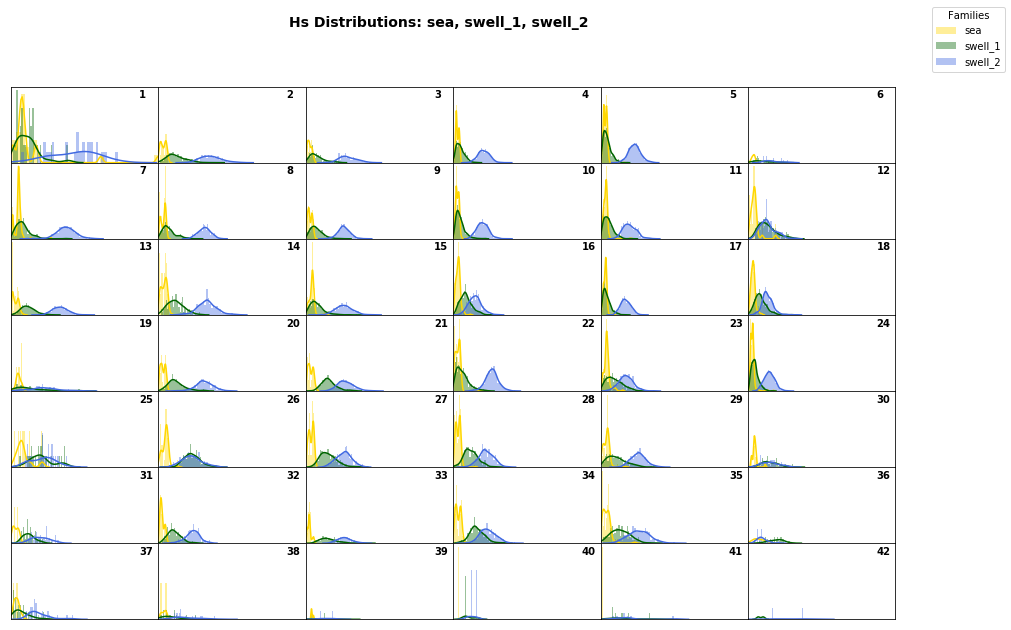

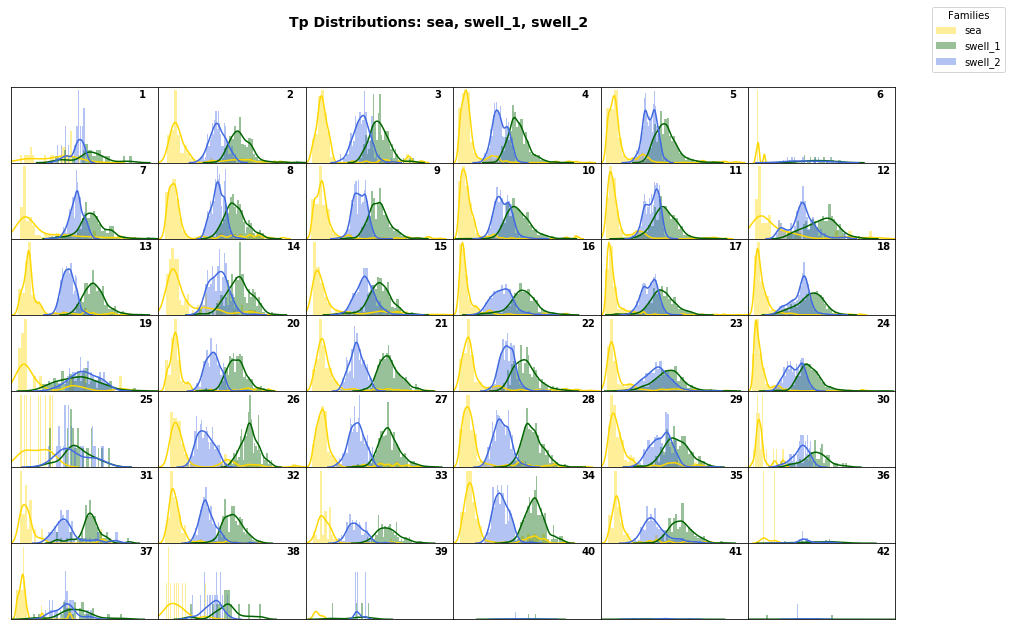

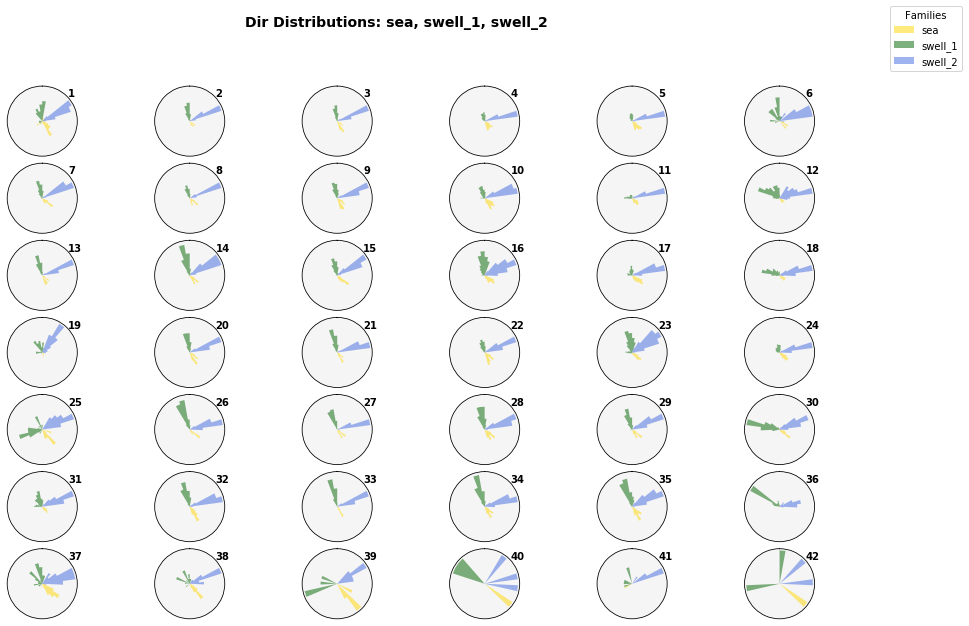

In [18]:
# Plot Waves Families by DWTs

# load waves families (full data)
WVS_fams = db.Load_WAVES_fams()

# DWTs bmus
DWTs = pred.KMA
BMUS = xr.Dataset(
    {'bmus':(('time',), DWTs['sorted_bmus_storms'].values[:])},
    coords = {'time': DWTs.time.values[:]}
)
n_clusters = 42

# common dates
dates_common= xds_common_dates_daily([WVS_fams, DWTs])

# waves and bmus at common dates
WVS_fams_sel = WVS_fams.sel(time=dates_common)
bmus_sel = BMUS.sel(time=dates_common).bmus.values[:]


# Plot Waves Families by DWTs
Plot_Waves_DWTs(WVS_fams_sel, bmus_sel, n_clusters);

